In [2]:
import ibis
from ibis import _
import streamlit as st

con = ibis.duckdb.connect("duck.db", extensions=['httpfs', 'spatial', 'h3'])

# Local cloud
minio_key = st.secrets["MINIO_KEY"]
minio_secret = st.secrets["MINIO_SECRET"]
query=   f'''
CREATE OR REPLACE SECRET secret2 (
    TYPE S3,
    KEY_ID '{minio_key}',
    SECRET '{minio_secret}',
    ENDPOINT 'minio.carlboettiger.info',
    URL_STYLE 'path',
    SCOPE 's3://cboettig/gbif'
);
'''
con.raw_sql(query)

## Limits are sometimes good 
#con.raw_sql("SET memory_limit = '20GB';")
#con.raw_sql("set threads=40;")

gbif = con.read_parquet("s3://cboettig/gbif/2024-10-01/**")

# can/should we add explicit spatial index to gbif first?  using RTree takes too much memory

2024-12-02 22:03:04.459 No runtime found, using MemoryCacheStorageManager


In [ ]:
# Copy to local cloud as parquet

(con
 .read_geo("/vsicurl/https://data.source.coop/cboettig/us-boundaries/mappinginequality.json")
 .to_parquet("s3://cboettig/gbif/mappinginequality.parquet")
)

# can/should we add explicit spatial index to mappinginequality polygons first? 
# would local duckdb table version be even better/faster? 


We iterate through the city list to do this efficiently.  

In [24]:
## select cities from the list we haven't yet written (allows resume).
import minio
import re

minio_key = st.secrets["MINIO_KEY"]
minio_secret = st.secrets["MINIO_SECRET"]
mc = minio.Minio("minio.carlboettiger.info", minio_key, minio_secret)
obj = mc.list_objects("cboettig", "gbif/redlined/", recursive=True)

pattern = r"gbif/redlined/|\.parquet$"
finished_cities = [re.sub(pattern, "",  i.object_name) for i in obj if not i.is_dir]

mappinginequality = con.read_parquet("s3://cboettig/gbif/mappinginequality.parquet")
all_cities = (mappinginequality.select(_.city, _.state)
              .distinct()
              .mutate(index = "state=" + _.state + "/" + "city=" + _.city)
              .execute()["index"]
             )

remaining_cities = set(all_cities) - set(finished_cities)


In [25]:
len(remaining_cities)
remaining_cities

{'state=SC/city=Sumter'}

In [26]:
%%time 

## And here we go, long-running loop over each city
for i in remaining_cities:
    gdf = (mappinginequality
           .mutate(index = "state=" + _.state + "/" + "city=" + _.city)
           .filter(_.index == i)
           .mutate(area = _.geom.area())
    )

    print(i)
    
    bounds =  gdf.execute().total_bounds
    points = (gbif
           .filter(_.decimallongitude >= bounds[0], 
                   _.decimallongitude < bounds[2], 
                   _.decimallatitude >= bounds[1], 
                   _.decimallatitude < bounds[3])
             )
                  
    (gdf
     .join(points, gdf.geom.intersects(points.geom))
     .to_parquet(f"s3://cboettig/gbif/redlined/{i}.parquet")
    )


state=SC/city=Sumter


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 15min 54s, sys: 4min 38s, total: 20min 33s
Wall time: 48.8 s


In [89]:
# standardize grades and consolidate to single parquet?

(con.read_parquet("s3://cboettig/gbif/redlined/**")
  .mutate(grade=_.grade.strip())
  .mutate(grade=_.grade.cases((('A', 'A'), ('B', 'B'), ('C', 'C'), ('D', 'D')), default = "None" )  )
  .to_parquet("s3://cboettig/gbif/redlined_cities_gbif.parquet")
)



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [96]:
%%time
# con.read_parquet("s3://cboettig/gbif/redlined/**")
## Testing

(con
  .read_parquet("s3://cboettig/gbif/redlined_cities_gbif.parquet")
#  .filter(_.city == "Los Angeles")
  .filter(_["class"] == "Aves")
  .group_by(_.grade)
  .agg(n = _.count(),
       area = _.area.sum())
  .mutate(density = _.n /_.area)
  .order_by(_.density.desc())
  .execute()
)


CPU times: user 2.59 s, sys: 22.9 s, total: 25.5 s
Wall time: 700 ms


,grade,n,area,density
0,A,3048483,1008.034173,3024.186167
1,B,5506468,2517.018555,2187.694639
2,D,3491760,1896.670719,1840.994309
3,C,6353620,3539.963360,1794.826487
4,None,6021724,16665.329460,361.332431


In [12]:
%%time 

## mean & sd within grade

df = (con
 .read_parquet("s3://cboettig/gbif/redlined_cities_gbif.parquet")
 .filter(_["class"] == "Aves")
# .filter(_.city == "Los Angeles")
 .group_by(_.city, _.grade)
 .agg(n = _.count(), area = _.area.sum())
 .mutate(density = _.n /_.area)
# .group_by(_.grade)
# .agg(mean = _.density.mean(),sd = _.density.std())
# .order_by(_.mean.desc())
# .execute()
)

CPU times: user 57.9 ms, sys: 20.2 ms, total: 78.1 ms
Wall time: 126 ms


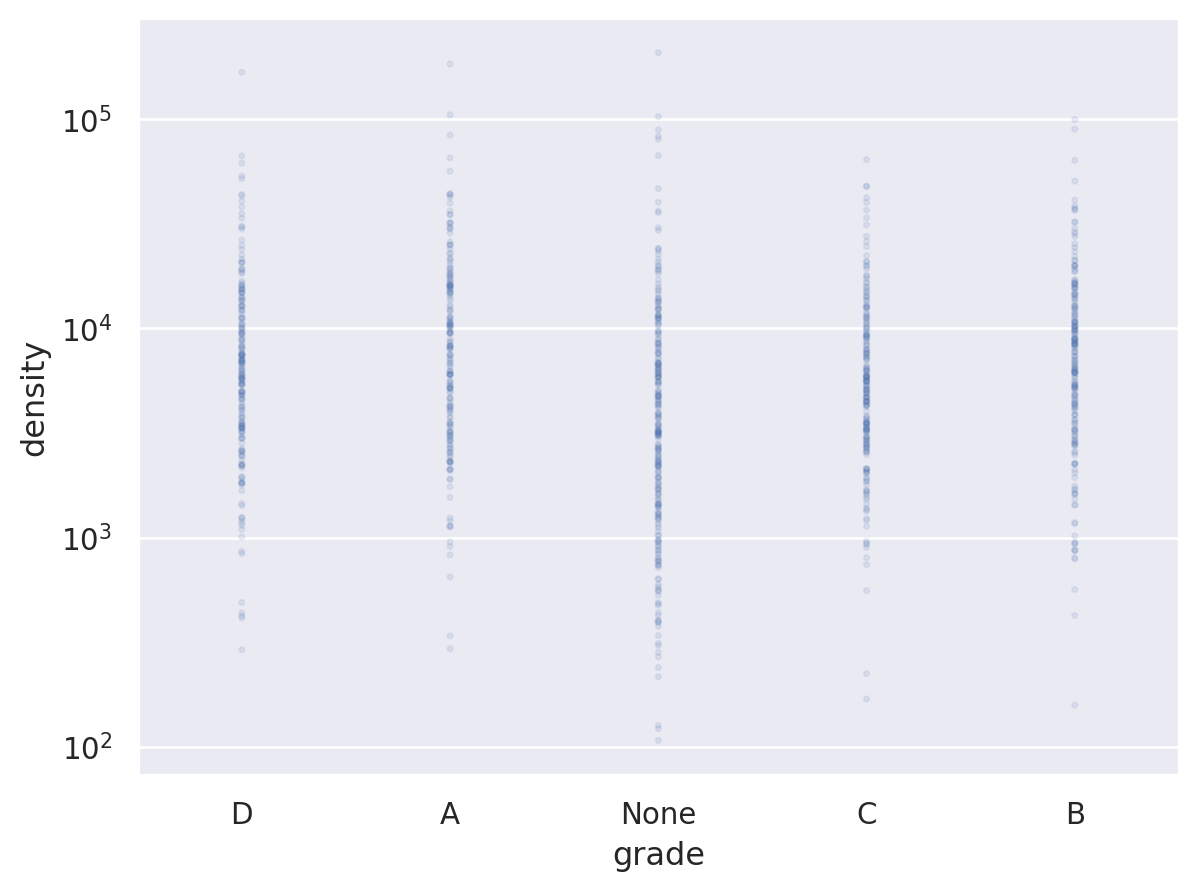

In [13]:
import seaborn.objects as so

so.Plot(df, x = "grade", y = "density").add(so.Dots(marker=".", alpha=0.1, fillalpha=0.1)).scale(y="log")

In [ ]:
## Overture-based areas
overture = (
    con.read_parquet('s3://overturemaps-us-west-2/release/2024-11-13.0/theme=divisions/type=division_area/*', 
                     filename=True, hive_partitioning=1)
usa = overture.filter(_.subtype=="country").filter(_.country == "US").select(_.geometry).execute()
ca = (overture
       .filter(_.country == "US", _.subtype == "region")
       .select('region', 'geometry')
       .filter(_.region == "US-CA")
       .execute()
      )

In [ ]:

## export in gdal formats?  not working?

# Workaround for generic DuckDB writes (e.g. ~ to_geo() )
# query = ibis.to_sql(sel)
# con.raw_sql(f"COPY ({query}) TO 's3://{bucket}/{dest2}'  WITH (FORMAT GDAL, DRIVER 'FlatGeoBuf');")
# con.raw_sql(f"COPY ({query}) TO 's3://{bucket}/{dest2}'  WITH  (FORMAT GDAL, DRIVER 'GeoJSON', LAYER_CREATION_OPTIONS 'WRITE_BBOX=YES');")
